# CNN Fatiuge

In [1]:
import tensorflow.compat.v1  as tf
import numpy as np
import os,sys
tf.compat.v1.disable_eager_execution()
import scipy.io as scio

In [2]:
X_train_mat = scio.loadmat('X_train-3Classes-50%overlap.mat')
key_name = list(X_train_mat.keys())[-1]
X_train=X_train_mat[key_name]
print(X_train.shape)

Y_train_mat = scio.loadmat('Y_train-3Classes-50%overlap.mat')
key_name = list(Y_train_mat.keys())[-1]
Y_train=Y_train_mat[key_name]
print(Y_train.shape)

(34334, 200, 9)
(34334, 1)


In [3]:
#只取前列数据
X_train=X_train[:,:,0:6]#只取前
print(X_train.shape)
print(Y_train.shape)

(34334, 200, 6)
(34334, 1)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 0)
#X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 0)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(30900, 200, 6)
(30900, 1)
(3434, 200, 6)
(3434, 1)


In [5]:
X_train=X_train.reshape(-1,200,6,1)
X_test=X_test.reshape(-1,200,6,1)

In [6]:
np.random.seed(42)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(42)
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
# Import Keras
from __future__ import print_function
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout,Flatten, Reshape, Softmax
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, TimeDistributed,LSTM,Bidirectional,BatchNormalization
#from keras import backend as K
from tensorflow.compat.v1.keras import backend as K
from attention import Attention
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# callbacks:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [8]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [9]:
# Initializing parameters
epochs = 200
batch_size = 256
timesteps = 200
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)
#input_shape = (timesteps, input_dim)

print(timesteps,input_dim,len(X_train))
print(n_classes)

200 6 30900
3


In [10]:
# Initiliazing the sequential model
input_shape = (256, 200, 6, 1)
model = Sequential()

model.add(Conv2D(32,(18,1),activation='relu',strides=(2,1),padding='SAME',input_shape=(200,6,1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Conv2D(64, (9, 1), activation='relu',padding='SAME'))
model.add(Conv2D(128, (3, 1), activation='relu',padding='SAME'))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Conv2D(128, (1, 6), activation='relu', padding='VALID'))
model.add(Flatten())

# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))

model.summary()
#-------------------
# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])#二分类：optimizer='adam', loss='binary_crossentropy'；多分类时激活函数改为softmax。损失函数改为：loss=‘categorical_crossentropy’

filepath="CNN-weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

mc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

tb = TensorBoard(log_dir='./logs',  # log 目录
                 histogram_freq=1,  # 按照何等频率（epoch）来计算直方图，0为不计算
                 batch_size=64,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0,
                 embeddings_layer_names=None,
                 embeddings_metadata=None)

es=EarlyStopping(monitor='val_loss', patience=14, verbose=2)
rp=ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.25,
    patience=8,#
    verbose=2,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

# callbacks_list = [mc,tb,es,rp]
callbacks_list =[mc,es,rp]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 6, 32)        608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 6, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 6, 64)         36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 6, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 6, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 1, 128)        98432     
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

In [11]:
# Training the model
#model2.load_weights("M2-weights-improvement-23-0.70.hdf5")
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_split=0.1,
          validation_data=None,
          shuffle=True,
          epochs=epochs,
          callbacks=callbacks_list)


Train on 27810 samples, validate on 3090 samples
Epoch 1/200
27810/27810 [==============================] - ETA: 0s - loss: 1.5597 - acc: 0.4554WARNING:tensorflow:From D:\Anaconda3\envs\tensorflow1\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_acc improved from -inf to 0.45599, saving model to CNN-weights-improvement-01-0.46.hdf5
27810/27810 [==============================] - 160s 6ms/sample - loss: 1.5597 - acc: 0.4554 - val_loss: 1.1045 - val_acc: 0.4560
Epoch 2/200
27810/27810 [==============================] - ETA: 0s - loss: 0.8108 - acc: 0.6215
Epoch 00002: val_acc improved from 0.45599 to 0.62880, saving model to CNN-weights-improvement-02-0.63.hdf5
27810/27810 [==============================] - 192s 7m

27810/27810 [==============================] - ETA: 0s - loss: 0.0580 - acc: 0.9879
Epoch 00026: val_acc did not improve from 0.95890
27810/27810 [==============================] - 168s 6ms/sample - loss: 0.0580 - acc: 0.9879 - val_loss: 0.1650 - val_acc: 0.9531
Epoch 27/200
27810/27810 [==============================] - ETA: 0s - loss: 0.0656 - acc: 0.9865
Epoch 00027: val_acc improved from 0.95890 to 0.95955, saving model to CNN-weights-improvement-27-0.96.hdf5
27810/27810 [==============================] - 168s 6ms/sample - loss: 0.0656 - acc: 0.9865 - val_loss: 0.1267 - val_acc: 0.9595
Epoch 28/200
27810/27810 [==============================] - ETA: 0s - loss: 0.0533 - acc: 0.9907
Epoch 00028: val_acc did not improve from 0.95955
27810/27810 [==============================] - 156s 6ms/sample - loss: 0.0533 - acc: 0.9907 - val_loss: 0.1782 - val_acc: 0.9447
Epoch 29/200
27810/27810 [==============================] - ETA: 0s - loss: 0.0555 - acc: 0.9901
Epoch 00029: val_acc did not i

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


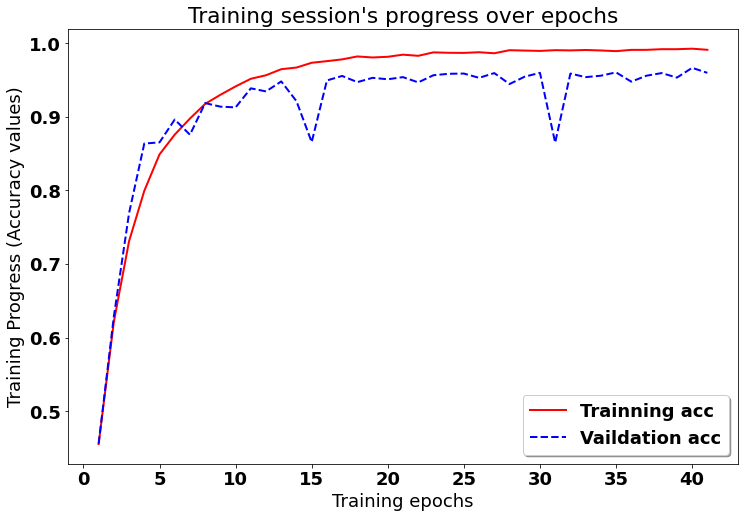

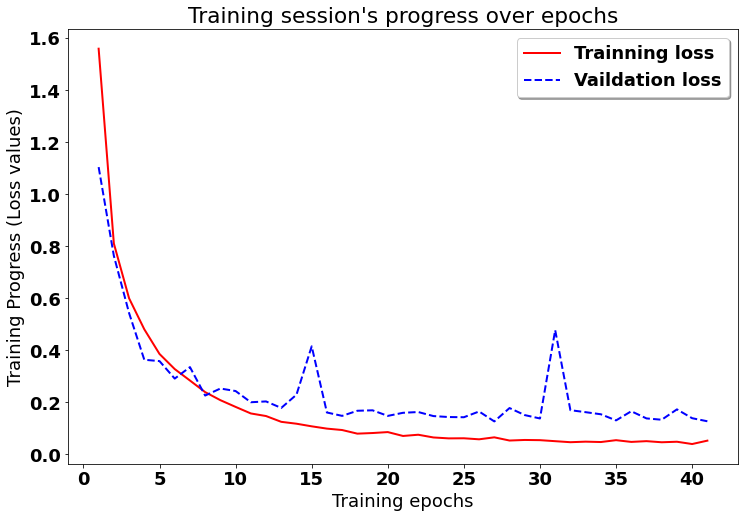

In [12]:
########画图
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
acc = history.history['acc']     #获取训练集准确性数据
val_acc = history.history['val_acc']    #获取验证集准确性数据
loss = history.history['loss']          #获取训练集错误值数据
val_loss = history.history['val_loss']  #获取验证集错误值数据
font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 8
plt.figure(figsize=(width, height))
epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'r',label='Trainning acc',linewidth=2)     #以epochs为横坐标，以训练集准确性为纵坐标
plt.plot(epochs,val_acc,'b--',label='Vaildation acc',linewidth=2) #以epochs为横坐标，以验证集准确性为纵坐标
plt.legend(loc='best', shadow=True)   #绘制图例，即标明图中的线段代表何种含义
plt.title("Training session's progress over epochs")
plt.ylabel('Training Progress (Accuracy values)')
plt.xlabel('Training epochs')

plt.figure(figsize=(width, height))
plt.plot(epochs,loss,'r',label='Trainning loss',linewidth=2)
plt.plot(epochs,val_loss,'b--',label='Vaildation loss',linewidth=2)
plt.legend(loc='best', shadow=True)   #绘制图例，即标明图中的线段代表何种含义
plt.title("Training session's progress over epochs")
plt.ylabel('Training Progress (Loss values)')
plt.xlabel('Training epochs') 
plt.show()    #显示所有图表

In [13]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
#model2.load_weights("M2-weights-improvement-45-0.97.hdf5")
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# confusion matrix
Y_pred=model.predict_classes(X_test)
print(Y_pred.shape)
# Y_pred=np.transpose([Y_pred])
# print(Y_pred.shape)

acc: 95.92%
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
(3434,)


| Confusion Matrix |
--------------------

 [[1303   59    1]
 [  46 1270   10]
 [   2   22  721]]


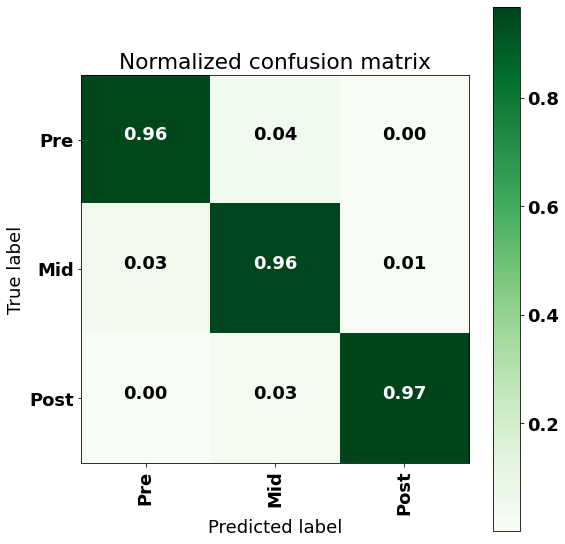

| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1363
           1       0.94      0.96      0.95      1326
           2       0.98      0.97      0.98       745

    accuracy                           0.96      3434
   macro avg       0.96      0.96      0.96      3434
weighted avg       0.96      0.96      0.96      3434



In [15]:
cm_cmap=plt.cm.Greens
cm = confusion_matrix(Y_test,Y_pred)


print('| Confusion Matrix |')
print('--------------------')
print('\n {}'.format(cm))
class_labels=['Pre','Mid','Post']
# plot confusin matrix
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
plt.show()
class_labels=[0,1,2]
# get classification report
print('| Classifiction Report |')
print('-------------------------')
classification_report = metrics.classification_report(Y_test,Y_pred,labels =class_labels)
# store report in results


print(classification_report)